In [25]:
import yfinance as yf
import numpy as np
import pandas as pd


from matplotlib import pyplot as plt
from datetime import date

In [27]:
# Load stock data using yfinance
spy = yf.Ticker("spy")
data = pd.DataFrame(spy.history(period="max", interval="1D"))
data = data[["Close", "Volume"]]
m, n = data.shape

data = data.reset_index(drop=False)
# Convert the 'Date' column to datetimey
data['Date'] = pd.to_datetime(data['Date'])

# Add target column
data['Target'] = data['Close'].shift(-1)

In [28]:
# Calculate MACD and Signal Line
short_window = 12  # 12-period EMA
long_window = 26   # 26-period EMA
signal_window = 9  # 9-period EMA

# Calculate MACD and Signal Line
macd = data['Close'].ewm(span=short_window, adjust=False).mean() - data['Close'].ewm(span=long_window, adjust=False).mean()
signal = macd.ewm(span=signal_window, adjust=False).mean()

# Initialize tracking variables
isBullish_list = []
bullish_counter = 0
bearish_counter = 0

# Loop through the data to check for MACD crossover persistence
for i in range(1, len(macd)):
    if macd.iloc[i] > signal.iloc[i] and macd.iloc[i-1] > signal.iloc[i-1]:  # Golden Cross
        bullish_counter += 1
        bearish_counter = 0
        if bullish_counter >= 4:
            isBullish_list.append(1)  # Bullish
        else:
            isBullish_list.append(2)  # Neutral (before 2 consecutive days)
    elif macd.iloc[i] < signal.iloc[i] and macd.iloc[i-1] < signal.iloc[i-1]:  # Death Cross
        bearish_counter += 1
        bullish_counter = 0
        if bearish_counter >= 4:
            isBullish_list.append(-1)  # Bearish
        else:
            isBullish_list.append(2)  # Neutral (before 2 consecutive days)
    else:
        # Reset counters when there's no persistence of bullish/bearish signal
        bullish_counter = 0
        bearish_counter = 0
        isBullish_list.append(2)  # Neutral state

# Adjust length of isBullish_list for the first element
isBullish_list = [2] + isBullish_list  # Add 2 for the first row since we start from the second row

# Add the isBullish column to the dataset
data['MACD_Status'] = isBullish_list

# Check if the market is in an uptrend for atleast 5 days (TBI)
data['200_MA'] = EMA_200 = data['Close'].rolling(window=200).mean()# Preview the dataset
data.head(17)

,Date,Close,Volume,Target,MACD_Status,200_MA
0,1993-01-29 00:00:00-05:00,24.608614,1003200,24.783648,2,NaN
1,1993-02-01 00:00:00-05:00,24.783648,480500,24.836147,2,NaN
2,1993-02-02 00:00:00-05:00,24.836147,201300,25.098698,2,NaN
3,1993-02-03 00:00:00-05:00,25.098698,529400,25.203703,2,NaN
4,1993-02-04 00:00:00-05:00,25.203703,531500,25.186209,2,NaN
5,1993-02-05 00:00:00-05:00,25.186209,492100,25.186209,1,NaN
6,1993-02-08 00:00:00-05:00,25.186209,596100,25.011192,1,NaN
7,1993-02-09 00:00:00-05:00,25.011192,122100,25.046202,1,NaN
8,1993-02-10 00:00:00-05:00,25.046202,379600,25.168713,1,NaN
9,1993-02-11 00:00:00-05:00,25.168713,19500,24.976183,1,NaN


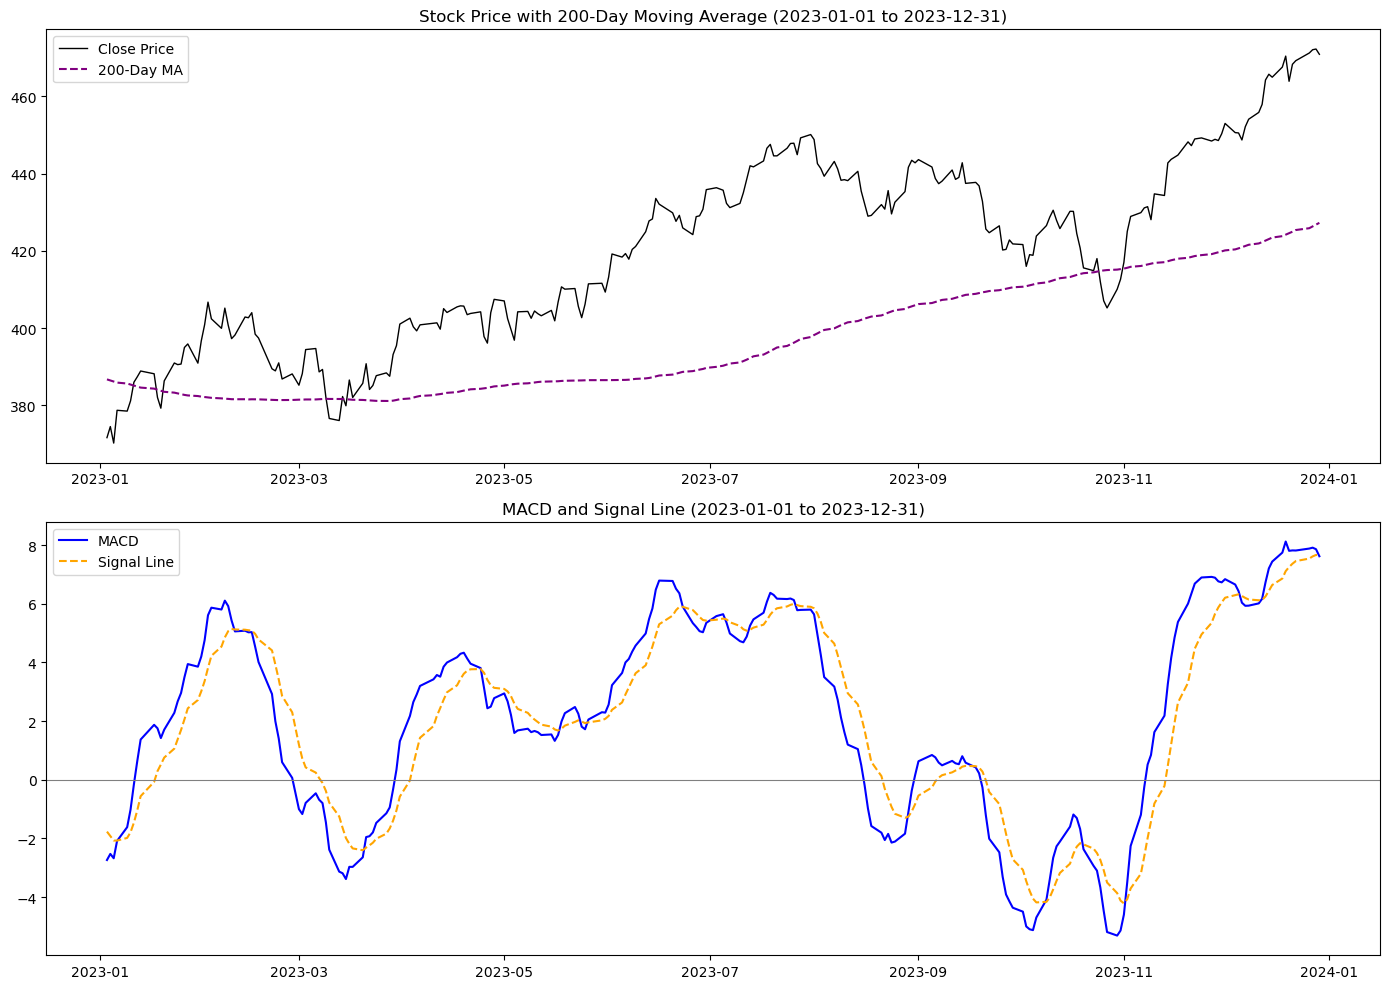

In [31]:
# Specify the start and end dates for the range you want to view
start_date = '2023-01-01'
end_date = '2023-12-31'

# Filter the data for the specified date range
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Plotting the MACD, Signal Line, and 200-day Moving Average for the filtered date range
plt.figure(figsize=(14, 10))

# Plot the Close price with 200-day MA
plt.subplot(2, 1, 1)
plt.plot(filtered_data['Date'], filtered_data['Close'], label='Close Price', color='black', linewidth=1)
plt.plot(filtered_data['Date'], filtered_data['200_MA'], label='200-Day MA', color='purple', linestyle='--')
plt.title(f'Stock Price with 200-Day Moving Average ({start_date} to {end_date})')
plt.legend()

# Plot the MACD and Signal Line
plt.subplot(2, 1, 2)
plt.plot(filtered_data['Date'], macd[filtered_data.index], label='MACD', color='blue', linewidth=1.5)
plt.plot(filtered_data['Date'], signal[filtered_data.index], label='Signal Line', color='orange', linestyle='--')
plt.title(f'MACD and Signal Line ({start_date} to {end_date})')
plt.legend()

plt.axhline(0, color='grey', linestyle='-', linewidth=.8)

# Show the plot
plt.tight_layout()
plt.show()


In [32]:
### Calculate RSI
# Calculate the price change for each day
data["Change"] = data['Close'].diff()

# Calculate up moves and down moves (get U and D)
data['U'] = data['Change'].apply(lambda x: x if x > 0 else 0)
data['D'] = data['Change'].apply(lambda x: abs(x) if x < 0 else 0)

# Average the up moves and down moves (get AvgU and AvgD)
# SMA Approach: 
N = 14
data['AvgU'] = data['U'].rolling(window=N).mean()
data['AvgD'] = data['D'].rolling(window=N).mean()

# # EMA Approach
# data['AvgU'] = data['U'].ewm(span=N, adjust=False).mean()
# data['AvgD'] = data['D'].ewm(span=N, adjust=False).mean()

# Wilder's Soothing Approach...

# Calculate Relative Strength (get RS)
data['RS'] = data['AvgU'] / data['AvgD']

# Calculate the Relative Strength Index (get RSI)
data['RSI'] = 100 - 100 / ( 1 + data['RS'])

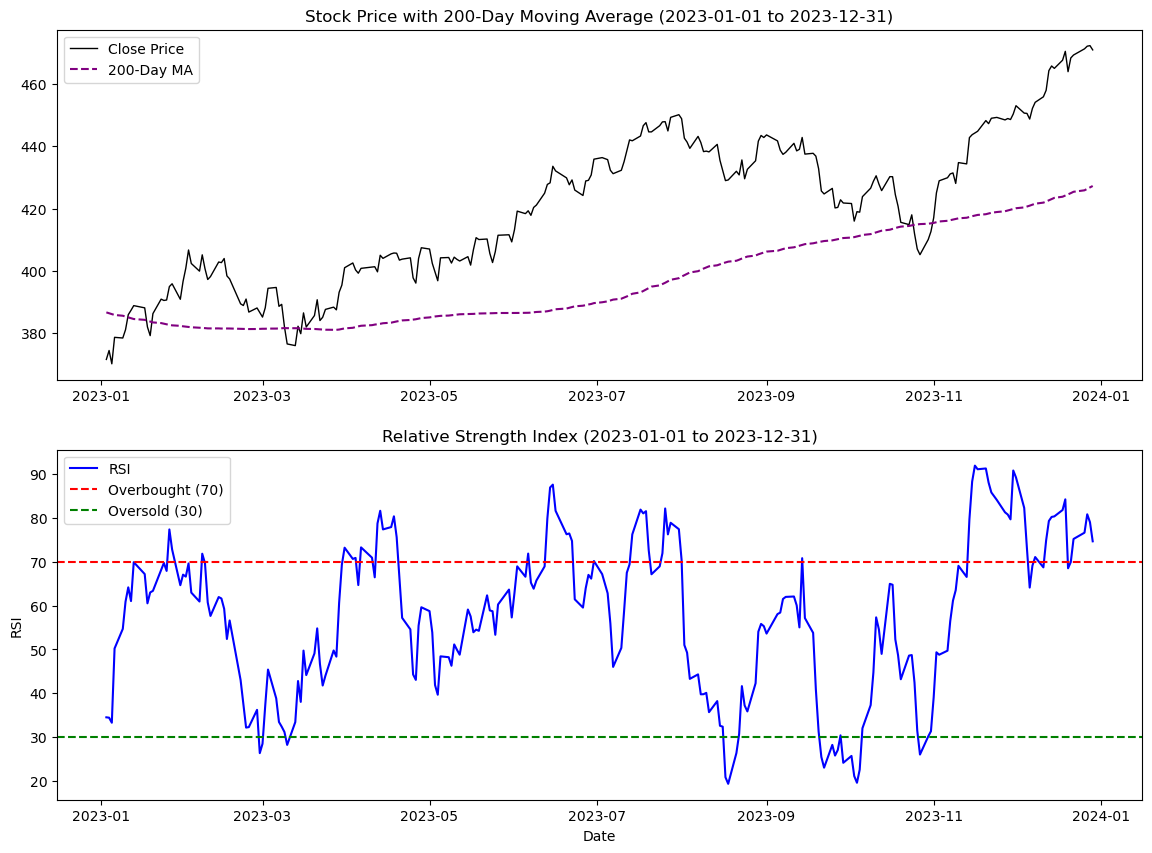

In [33]:
# graphing of RSI

# Specify the start and end dates for the range you want to view
start_date = '2023-01-01'
end_date = '2023-12-31'

# Filter the data for the specified date range
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

plt.figure(figsize=(14, 10))

# Plot the Close price with 200-day MA
plt.subplot(2, 1, 1)
plt.plot(filtered_data['Date'], filtered_data['Close'], label='Close Price', color='black', linewidth=1)
plt.plot(filtered_data['Date'], filtered_data['200_MA'], label='200-Day MA', color='purple', linestyle='--')
plt.title(f'Stock Price with 200-Day Moving Average ({start_date} to {end_date})')
plt.legend()
# Plotting the RSI

# Plot the RSI line
plt.subplot(2, 1, 2)
plt.plot(filtered_data['Date'], filtered_data['RSI'], label='RSI', color='blue', linewidth=1.5)

# Add horizontal lines for the overbought and oversold levels
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')

# Add title and labels
plt.title(f'Relative Strength Index ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('RSI')

# Show the legend
plt.legend()

# Display the plot
plt.show()


In [36]:
# 9 and 20 ema

# data['9 EMA'] = data['Close'].rolling(window=9).mean()


In [39]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Define the start date and dynamically find the end date
start_date = "1995-01-01"
end_date = data['Date'].max() - pd.Timedelta(days=1) # Most recent date in the dataset

# Apply the date range filter
filtered_data = data[
    (data['Date'] >= start_date) & (data['Date'] <= end_date)
]

# Select specific columns from the filtered data
filtered_data = filtered_data[['Date', 'Close', 'Volume', 'MACD_Status', 'RSI', 'Target']]

# Display the resulting filtered data
filtered_data


,Date,Close,Volume,MACD_Status,RSI,Target
486,1995-01-03 00:00:00-05:00,26.987080,324300,1,63.628590,27.116007
487,1995-01-04 00:00:00-05:00,27.116007,351800,1,64.218783,27.116007
488,1995-01-05 00:00:00-05:00,27.116007,89800,1,61.179158,27.143644
489,1995-01-06 00:00:00-05:00,27.143644,448400,1,59.818793,27.171274
490,1995-01-09 00:00:00-05:00,27.171274,36800,1,56.962656,27.198914
...,...,...,...,...,...,...
8005,2024-11-13 00:00:00-05:00,597.190002,47388600,1,67.670821,593.349976
8006,2024-11-14 00:00:00-05:00,593.349976,38904100,1,63.145324,585.750000
8007,2024-11-15 00:00:00-05:00,585.750000,75988800,1,54.083656,588.150024
8008,2024-11-18 00:00:00-05:00,588.150024,37084100,2,55.170186,590.299988


### Create Model


In [53]:
from sklearn.model_selection import train_test_split
import scipy


C:\Users\jabba\anaconda3\python.exe
C:\Users\jabba\AppData\Local\Microsoft\WindowsApps\python.exe


'which' is not recognized as an internal or external command,
operable program or batch file.
